In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist 
from keras import utils 
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
# convert class vectors to binary class matrices
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [5]:
kernel_s3 = (3, 3)
kernel_s5 = (5, 5)

In [6]:
model = Sequential(
    [
        Input(shape=input_shape),

        Conv2D(16, kernel_size=kernel_s5, activation="relu", name="conv2d_1"),
        # Conv2D(32, kernel_size=kernel_size, activation="relu", name="conv2d_2"),
        Conv2D(16, kernel_size=kernel_s5, activation="relu", name="conv2d_3"),
        # Conv2D(64, kernel_size=kernel_size, activation="relu", name="conv2d_4"),
        BatchNormalization(name="batchnorm_1"), 

        MaxPooling2D(pool_size=(2,2), name="maxpool2d_1"),
        Dropout(0.25, name="dropout_1"),
        
        Conv2D(32, kernel_size=kernel_s3, activation="relu", name="conv2d_5"),
        Conv2D(32, kernel_size=kernel_s3, activation="relu", name="conv2d_6"),
        BatchNormalization(name="batchnorm_2"), 
        
        MaxPooling2D(pool_size=(2,2), name="maxpool2d_2"),
        Dropout(0.25, name="dropout_2"),
        Flatten(name="flatten"),
        
        Dense(32, "relu", name="fc1"),
        BatchNormalization(name="batchnorm_3"), 
        
        Dense(16, "relu", name="fc2"),
        BatchNormalization(name="batchnorm_4"), 
        # Dense(16, "relu", name="fc3"),
        Dense(num_classes, activation="softmax", name="output"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        416       
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 16)        6416      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 20, 20, 16)       64        
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 10, 10, 16)        0         
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          4640      
                                                        

In [7]:
batch_size = 128
epochs = 10
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

In [8]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 22s 54ms/step - loss: 0.5385 - accuracy: 0.8621 - val_loss: 1.9234 - val_accuracy: 0.2749
Epoch 2/10
375/375 [==============================] - 20s 54ms/step - loss: 0.1193 - accuracy: 0.9689 - val_loss: 0.0695 - val_accuracy: 0.9805
Epoch 3/10
375/375 [==============================] - 24s 64ms/step - loss: 0.0757 - accuracy: 0.9793 - val_loss: 0.0482 - val_accuracy: 0.9864
Epoch 4/10
375/375 [==============================] - 26s 70ms/step - loss: 0.0615 - accuracy: 0.9815 - val_loss: 0.0526 - val_accuracy: 0.9838
Epoch 5/10
375/375 [==============================] - 27s 71ms/step - loss: 0.0507 - accuracy: 0.9851 - val_loss: 0.0394 - val_accuracy: 0.9885
Epoch 6/10
375/375 [==============================] - 36s 97ms/step - loss: 0.0461 - accuracy: 0.9858 - val_loss: 0.0412 - val_accuracy: 0.9873
Epoch 7/10
375/375 [==============================] - 36s 97ms/step - loss: 0.0396 - accuracy: 0.9877 - val_loss: 0.0321 - val_accuracy:

In [9]:
def plot_history(history, metrics, model_name:str):
    fig = plt.figure(figsize=[8, 4])
    for metric in metrics:
        plt.plot(history.history[metric], label='train '+ metric)
        plt.plot(history.history['val_' + metric], label='val ' + metric)        
    plt.legend()    
    plt.xlabel('epoch')
    plt.ylabel(" ".join(metrics))
    plt.xticks(list(range(0, len(history.history[metrics[0]]), 2)))
    plt.grid(visible=True)
    plt.title(model_name + " training history [" + " ".join(metrics) + "]")

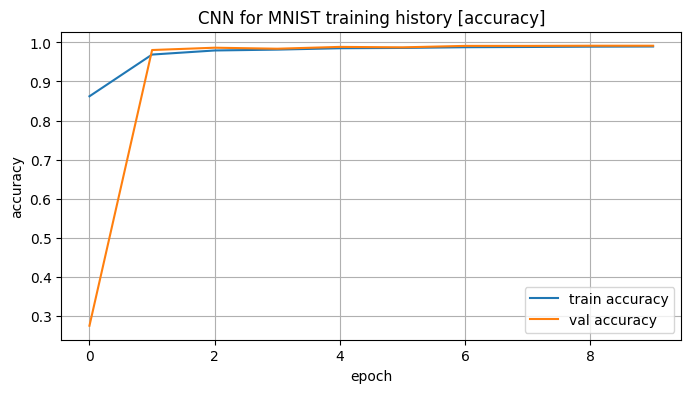

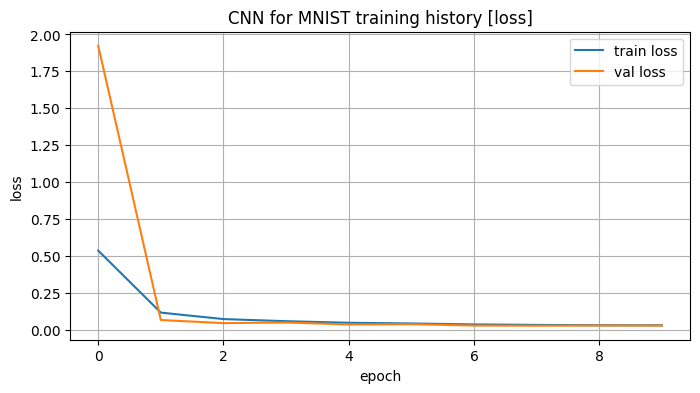

In [10]:
plot_history(history=history, metrics=["accuracy"],model_name="CNN for MNIST")
plot_history(history=history, metrics=["loss"],model_name="CNN for MNIST")

In [11]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.0255 - accuracy: 0.9920


[0.025479067116975784, 0.9919999837875366]